In [16]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import time
from pyDOE import lhs
np.random.seed(1234)
tf.random.set_seed(1234)


# *Data Prep*

Training and Testing data is prepared from the solution file

In [17]:
alp= np.linspace(0,1,3000)
alp_uvtest = tf.reshape(alp,[3000,1])
lb = alp_uvtest[0]
ub = alp_uvtest[-1]


# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [18]:
def trainingdata(N_f):
    '''boundary'''

    #left
    leftedge_alp = 0
    leftedge_u = -1
    leftedge_v = 0

    #right
    rightedge_alp = 1
    rightedge_u = 1
    rightedge_v = 0

    alp_uvtrain = np.vstack([leftedge_alp, rightedge_alp])
    u_train = np.vstack([leftedge_u, rightedge_u])
    v_train = np.vstack([leftedge_v, rightedge_v])

    # Latin Hypercube sampling for collocation points
    alp_f_train = lb + (ub-lb)*lhs(1,N_f)
    alp_f_train = np.vstack((alp_f_train, alp_uvtrain)) 

    return alp_f_train, alp_uvtrain, u_train, v_train

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [19]:
class PertudynNN(tf.Module): 
    def __init__(self,layers, name = None):
        self.W = []
        self.parameters = 0
        
        for i in range(len(layers)-1):
            input_dim = layers[i]
            output_dim = layers[i+1]

            std_dv = np.sqrt((2.0/(input_dim + output_dim)))
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim

    def evaluate(self,alp):
        alp = (alp-lb)/(ub-lb)
        a = alp
        for i in range(len(layers)-2):
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) 
        return a
    
    def get_weights(self):

        parameters_1d = []  
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 
    
    def loss_BC(self,alp,yu,yv):

        loss_u = tf.reduce_sum(tf.square(yu-tf.reshape((self.evaluate(alp)[:,0]),(2,1))))
        loss_v = tf.reduce_sum(tf.square(yv-tf.reshape((self.evaluate(alp)[:,1]),(2,1))))
        return loss_u, loss_v

    '''
    def loss_PDE(self, alp_to_train_f):
    
        g = tf.Variable(alp_to_train_f, dtype = 'float64', trainable = False)
        alp_f = g


        with tf.GradientTape(persistent=True) as tape:

            tape.watch(alp_f)
            z = self.evaluate(alp_f)
            u = z[:,0]
            v = z[:,1]
            u_x = tape.gradient(u,alp_f)
            v_x = tape.gradient(v,alp_f)
            lda2 = (tf.pow((u-tf.pow(u,3)-u*tf.pow(v,2)),2) + tf.pow(v,2)*tf.pow((1+tf.pow(u,2)),2))/(tf.pow(u_x,2)*tf.pow(v_x,2))
        lda2_x = tape.gradient(lda2,alp_f)
        u_xx = tape.gradient(u_x, alp_f)
        v_xx = tape.gradient(v_x, alp_f)

        
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(alp_f)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(alp_f)
                z = self.evaluate(alp_f)
                u = z[:,0]
                v = z[:,1]
            u_x = tape2.gradient(u,alp_f)
            v_x = tape2.gradient(v,alp_f)
            lda2 = (tf.pow((u-tf.pow(u,3)-u*tf.pow(v,2)),2) + tf.pow(v,2)*tf.pow((1+tf.pow(u,2)),2))/(tf.pow(u_x,2)*tf.pow(v_x,2))
        u_xx = tape1.gradient(u_x, alp_f)
        v_xx = tape1.gradient(v_x, alp_f)
        lda2_x = tape1.gradient(lda2,alp_f)
        
        del tape1
        del tape2


        f = lda2 * u_xx + (-4*(u**3)+3*(u**5)+6*(u**3)*(v**2)+u*(v**4)+u) + 0.5*lda2_x*u_x + lda2 * v_xx - 3*(u**4)*v + 2*(u**2)*(v**3)+v+0.5*lda2_x*v_x

        f1 = lda2 * u_xx + (-4*(u**3)+3*(u**5)+6*(u**3)*(v**2)+u*(v**4)+u) + 0.5*lda2_x*u_x
        f2 = lda2 * v_xx - 3*(u**4)*v + 2*(u**2)*(v**3)+v+0.5*lda2_x*v_x
        
        loss_f = tf.reduce_mean(tf.square(f1))+ tf.reduce_mean(tf.square(f2))

        return loss_f
    '''

    def loss_PDE(self, alp_to_train_f):
        g = tf.Variable(alp_to_train_f, dtype = 'float64', trainable = False)
        alp_f = g
        with tf.GradientTape(persistent=True) as tape:

            tape.watch(alp_f)
            z = self.evaluate(alp_f)
            u = tf.reshape(z[:,0],(N_f+2,1))
            v = tf.reshape(z[:,1],(N_f+2,1))
            u_x = tape.gradient(u,alp_f)
            v_x = tape.gradient(v,alp_f)
            #lda2 = (tf.pow((z[:,0]-tf.pow(z[:,0],3)-z[:,0]*tf.pow(z[:,1],2)),2) + tf.pow(z[:,1],2)*tf.pow((1+tf.pow(z[:,0],2)),2))/(tf.pow(u_x,2)*tf.pow(v_x,2))
            lda2temp1 = ((u-u*u*u-u*v*v)*(u-u*u*u-u*v*v)+v*v*(1+u*u)*(1+u*u))
            lda2temp1 = tf.reshape(lda2temp1,[N_f+2,1])
            lda2temp2 = (u_x*u_x+v_x*v_x)
            lda2 = lda2temp1/lda2temp2
            
        
        lda2_x = tape.gradient(lda2,alp_f)
        u_xx = tape.gradient(u_x, alp_f)
        v_xx = tape.gradient(v_x, alp_f)

        del tape
        temp1 = tf.reshape((-4*(u*u*u)+3*(u*u*u*u*u)+6*(u*u*u)*(v*v)+u*(v*v*v*v)+u),(N_f+2,1))
        temp2 = tf.reshape((3*(u*u*u*u*v) + 2*(u*u)*(v*v*v)+v),(N_f+2,1))
        #f = lda2 * u_xx + (-4*(z[:,0]**3)+3*(z[:,0]**5)+6*(z[:,0]**3)*(z[:,0]**2)+z[:,0]*(z[:,1]**4)+z[:,0]) + 0.5*lda2_x*u_x + lda2 * v_xx - 3*(z[:,0]**4)*z[:,1] + 2*(z[:,0]**2)*(z[:,1]**3)+z[:,1]+0.5*lda2_x*v_x
        
        f1 = lda2 * u_xx - temp1 + 0.5*lda2_x*u_x
        f2 = lda2 * v_xx - temp2 + 0.5*lda2_x*v_x
        loss_f = tf.reduce_mean(tf.square(f1))+tf.reduce_mean(tf.square(f2))
        #loss_f = tf.reduce_mean(tf.square(f1+f2))
        """
        f = lda2 * u_xx + temp1 + 0.5*lda2_x*u_x + lda2 * v_xx + temp2 +0.5*lda2_x*v_x
        loss_f = tf.reduce_mean(tf.square(f))
        """

        return loss_f

    def loss(self,alp,yu,yv,g):

        loss_u, loss_v = self.loss_BC(alp,yu,yv)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_v + loss_f

        return loss, loss_u, loss_v, loss_f    

    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_v, loss_f = self.loss(alp_uvtrain, u_train, v_train, alp_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()

    def optimizer_callback(self,parameters):
               
        loss_value, loss_u,loss_v, loss_f = self.loss(alp_uvtrain, u_train, v_train, alp_f_train)     
        tf.print(loss_value, loss_u,loss_v, loss_f)

0.57515033558723838 0.57458683977513436 0.00027072312306485578 0.00029277268903918661
0.28206186901120794 0.28174673906041225 0.00026043629686550458 5.469365393017478e-05
0.021622213458736633 0.01828713167187624 0.0013044768511924593 0.0020306049356679347
0.0036551965801045741 0.0016383020488928862 0.00094532008485036765 0.0010715744463613206
0.00042333201634009616 9.2772067610297012e-05 9.3654712826606913e-05 0.00023690523590319225
0.0001405996744824514 1.6299480228842848e-06 4.696105764309568e-05 9.2008668816471434e-05
8.63771444511402e-05 3.0481376670250154e-07 2.1366526156993939e-05 6.4705804527443754e-05
7.2221619289584659e-05 2.0340377208531574e-08 8.5829702362365846e-06 6.3618308676139539e-05
7.2026713064389e-05 7.6706091071529839e-09 8.8873324741603e-06 6.3131709981121545e-05
7.1592283554635191e-05 1.2118888600981674e-07 9.1565699937267632e-06 6.2314524674898607e-05
7.00890220553759e-05 8.4597277244555706e-07 9.5895715013884556e-06 5.9653477781541889e-05
6.6744970439121162e-05 

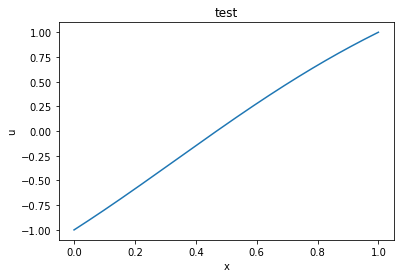

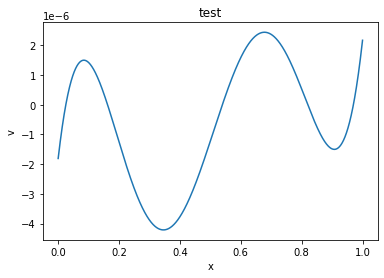

In [20]:
N_f = 1000 #Total number of collocation points 

# Training data
alp_f_train, alp_uvtrain, u_train, v_train = trainingdata(N_f)

layers = np.array([1,20,20,20,20,2]) #2 hidden layers

PINN = PertudynNN(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

# print(results)

PINN.set_weights(results.x)
u_pred = PINN.evaluate(alp_uvtest)[:,0]
v_pred = PINN.evaluate(alp_uvtest)[:,1]

fig,ax = plt.subplots()
plt.plot(alp_uvtest,u_pred)
plt.xlabel('x')
plt.ylabel('u')
plt.title('test')
plt.show()

fig,ax = plt.subplots()
plt.plot(alp_uvtest,v_pred)
plt.xlabel('x')
plt.ylabel('v')
plt.title('test')
plt.show()

In [15]:
print(alp_uvtest[2999])
print(v_pred[2999])

tf.Tensor([1.], shape=(1,), dtype=float64)
tf.Tensor(2.1690790604524113e-06, shape=(), dtype=float64)


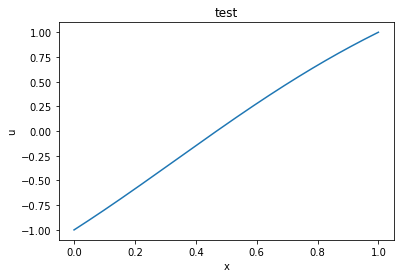

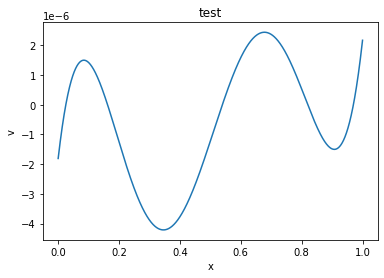

In [12]:
u_pred = PINN.evaluate(alp_uvtest)[:,0]
v_pred = PINN.evaluate(alp_uvtest)[:,1]

fig,ax = plt.subplots()
plt.plot(alp_uvtest,u_pred)
plt.xlabel('x')
plt.ylabel('u')
plt.title('test')
plt.show()

fig,ax = plt.subplots()
plt.plot(alp_uvtest,v_pred)
plt.xlabel('x')
plt.ylabel('v')
plt.title('test')
plt.show()

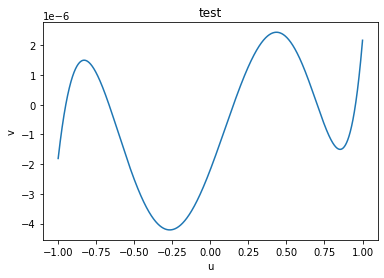

In [13]:
fig,ax = plt.subplots()
plt.plot(u_pred,v_pred)
plt.xlabel('u')
plt.ylabel('v')
plt.title('test')
plt.show()


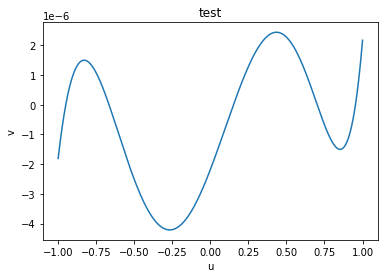

In [14]:
newtest= np.linspace(0,1,10000)
new_alp_uvtest = tf.reshape(newtest,[10000,1])

u_pred_new = PINN.evaluate(new_alp_uvtest)[:,0]
v_pred_new = PINN.evaluate(new_alp_uvtest)[:,1]

fig,ax = plt.subplots()
plt.plot(u_pred_new,v_pred_new)
plt.xlabel('u')
plt.ylabel('v')
plt.title('test')
plt.show()

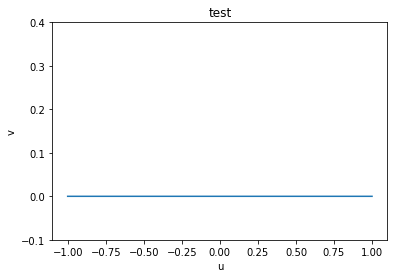

In [21]:
fig,ax = plt.subplots()
plt.plot(u_pred_new,v_pred_new)
plt.xlabel('u')
plt.ylabel('v')
plt.title('test')
plt.ylim([-0.1, 0.4])
plt.show()

